# 4. Сверточные нейронные сети.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np

from torchvision.datasets import ImageFolder

from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
import seaborn as sns

import zipfile
from tqdm import tqdm
import pandas as pd

In [3]:
import time

def time_since(since):
    now = time.time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои.
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [4]:
train_set = datasets.FashionMNIST(root = './data/FashionMNIST',
                                              download = True,
                                              train = True,
                                              transform = transforms.Compose([transforms.ToTensor(),]))
test_set = datasets.FashionMNIST(root = './data/FashionMNIST',
                                             download=True,
                                             train=False,
                                             transform = transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:01<00:00, 18088268.88it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 382866.43it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6054533.68it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15302818.56it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



In [5]:
batch_size = 50
train_dataset = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          shuffle=True)

print("The train set contains {} images, in {} batches".format(len(train_dataset.dataset), len(test_dataset)))
print("The test set contains {} images, in {} batches".format(len(test_dataset.dataset), len(test_dataset)))

The train set contains 60000 images, in 200 batches
The test set contains 10000 images, in 200 batches


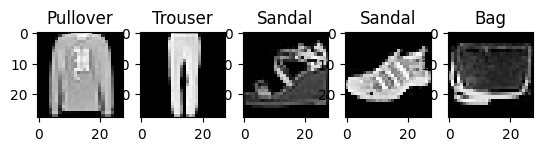

In [6]:
examples = enumerate(train_dataset)
batch_idx, (example_data, example_targets) = next(examples)
fashion_mnist_label_list = ['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot']
f, ax = plt.subplots(1, 5)
for i in range(5):
  ax[i].imshow(example_data[i].numpy().squeeze(), cmap = 'Greys_r')
  ax[i].set_title(fashion_mnist_label_list[example_targets[i]])
plt.show()

In [13]:
# Предложить архитектуру модели для решения задачи

class NN_Model(nn.Module):
    def __init__(self, n_features, n_hidden_neurons):
        super(NN_Model, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_features, n_hidden_neurons)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [14]:
# Посчитать количество параметров модели.

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


n_features, n_hidden_neurons = 28*28, 256
model = NN_Model(n_features, n_hidden_neurons)
count_parameters(model)

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |   200704   |
|  fc1.bias  |    256     |
| fc2.weight |   32768    |
|  fc2.bias  |    128     |
| fc3.weight |    8192    |
|  fc3.bias  |     64     |
| fc4.weight |    640     |
|  fc4.bias  |     10     |
+------------+------------+
Total Trainable Params: 242762


242762

In [15]:
# Обучить модель

n_features, n_hidden_neurons = 28*28, 256
n_epoch = 15 + 1
lr=0.005
criterion = nn.CrossEntropyLoss()

model = NN_Model(n_features, n_hidden_neurons)
optimizer = optim.Adam(model.parameters(), lr = lr)
losses_list = []
log_interval = 1

start = time.time()
for epoch in range(n_epoch):
    running_loss = 0
    for images, target in train_dataset:
        # images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses = running_loss/len(train_dataset)
    if epoch % log_interval == 0:
      print("Epoch: {}/{} |".format(epoch, n_epoch-1),
            "{}|".format(time_since(start)),
            "Training loss: {:.3f}..".format(losses))
    losses_list.append(losses)
print('Finished Training')

Epoch: 0/15 | 0m 16s| Training loss: 0.521..
Epoch: 1/15 | 0m 36s| Training loss: 0.395..
Epoch: 2/15 | 0m 55s| Training loss: 0.364..
Epoch: 3/15 | 1m 17s| Training loss: 0.344..
Epoch: 4/15 | 1m 38s| Training loss: 0.329..
Epoch: 5/15 | 2m 0s| Training loss: 0.322..
Epoch: 6/15 | 2m 20s| Training loss: 0.315..
Epoch: 7/15 | 2m 40s| Training loss: 0.308..
Epoch: 8/15 | 3m 1s| Training loss: 0.304..
Epoch: 9/15 | 3m 21s| Training loss: 0.293..
Epoch: 10/15 | 3m 43s| Training loss: 0.292..
Epoch: 11/15 | 4m 2s| Training loss: 0.282..
Epoch: 12/15 | 4m 23s| Training loss: 0.280..
Epoch: 13/15 | 4m 43s| Training loss: 0.280..
Epoch: 14/15 | 5m 4s| Training loss: 0.271..
Epoch: 15/15 | 5m 26s| Training loss: 0.267..
Finished Training


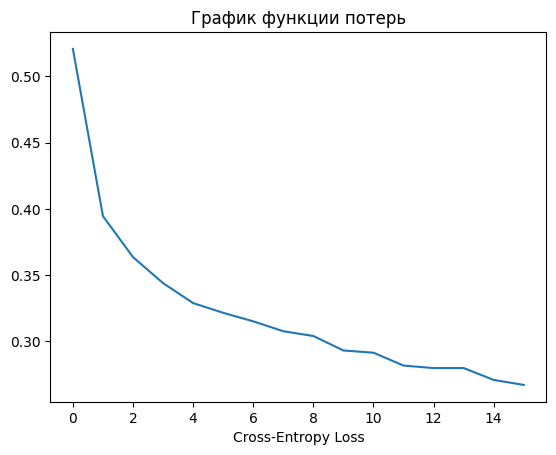

In [16]:
# Вывести график функции потерь по эпохам.

plt.plot(range(len(losses_list)), losses_list)
plt.title('График функции потерь')
plt.xlabel('Эпоха')
plt.xlabel('Cross-Entropy Loss')
plt.show()

In [ ]:
def test(debug=False):
    model.eval()
    test_loss = 0
    correct = 0
    true_list = []
    pred_list = []
    with torch.no_grad():
        for data, target in test_dataset:
            images = data.view(data.shape[0], -1)
            output = model(images)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            true_list += target.numpy().tolist()
            pred_list += np.squeeze(pred.numpy()).tolist()
        if debug:
            return output
    test_loss /= len(test_dataset.dataset)
    print('\nTest set: \nAvg. loss: {:.4f} \nAccuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dataset.dataset), 100. * correct / len(test_dataset.dataset)))
    return (pred_list, true_list)

In [19]:
# Вывести значение accuracy на тестовом множестве.
model.eval()
test_loss = 0
# correct = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in test_dataset:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred))
        for i in range(target.shape[0]):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = correct[i].item()
            try:
              result_[target_i] += correct[i].item()
            except:
              result_[target_i] = 1
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(test_dataset.dataset)

print(f'Avg. loss: {test_loss:.4f}')
print(f'Avg. accuracy: {np.sum(list(result_.values()))/np.sum(list(result_v.values())):.4f}\n')
for i in range(10):
    print(f'{fashion_mnist_label_list[i]} => {result_[i]/result_v[i]:.2f}({result_[i]}/{result_v[i]})')

Avg. loss: 0.0084
Avg. accuracy: 0.8606

T-shirt/top => 0.86(865/1000)
Trouser => 0.96(962/1000)
Pullover => 0.65(648/999)
Dress => 0.89(885/1000)
Coat => 0.89(891/1000)
Sandal => 0.94(938/1000)
Shirt => 0.52(518/1000)
Sneaker => 0.97(967/1000)
Bag => 0.97(974/1000)
Ankle Boot => 0.96(956/999)


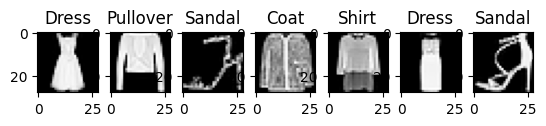

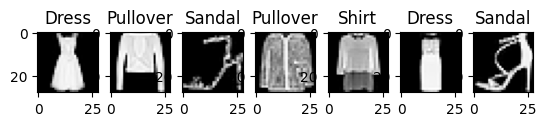

In [20]:
# Продемонстрировать работу модели: вывести несколько изображений,
# указать над ними правильный класс и класс, предсказанный моделью.

dataiter = iter(test_dataset)
images, labels = next(dataiter)

f, ax = plt.subplots(1, 7)
for i in range(7):
  img = images[i].resize_(1, 784)
  ax[i].imshow(images[i].numpy().squeeze(), cmap = 'Greys_r')
  ax[i].set_title(fashion_mnist_label_list[labels[i]])
plt.show()


f, ax = plt.subplots(1, 7)
for i in range(7):
  img = images[i].resize_(1, 784)
  res = model(img).detach().numpy().argmax()
  ax[i].imshow(images[i].numpy().squeeze(), cmap = 'Greys_r')
  ax[i].set_title(fashion_mnist_label_list[res])
plt.show()

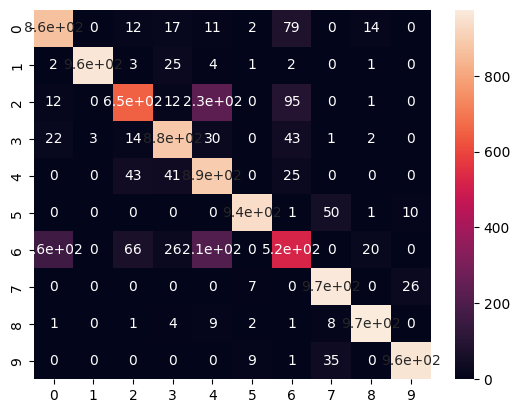

In [22]:
# Вывести матрицу ошибок.
matrix=confusion_matrix(true_list, pred_list)
ax = sns.heatmap(matrix, annot=True)
plt.show()

In [23]:
# Сохранить модель
torch.save(model.state_dict(), 'model1.pt')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [24]:
class CNN_Network(nn.Module):
  def __init__(self):
    super(CNN_Network,self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    self.conv2_drop5 = nn.Dropout(0.5) # p=0.5
    self.conv2_drop2 = nn.Dropout(0.2) # p=0.5
    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(64*4*4, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 10)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
      x = self.relu(self.max_pool(self.conv1(x))) # первый сверточный слой
      x = self.relu(self.max_pool(self.conv2_drop5(self.conv2(x)))) # второй сверточный
      x = x.view(-1, 64*4*4) # в двухмерный тензор с shape: (batch, 20*4*4)
      x = self.relu(self.fc1(x)) # первый полносвязный слой
      x = self.conv2_drop5(x)
      x = self.relu(self.fc2(x)) # второй полносвязный слой
      x = self.conv2_drop2(x)
      x = self.relu(self.fc3(x)) # третий полносвязный слой
      x = self.fc4(x) # четвертый полносвязный слой
      return self.softmax(x)

  def forward_1l(self, x):
      x = self.relu(self.max_pool(self.conv1(x))) # первый сверточный слой
      return x

In [25]:
model = CNN_Network()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
n_epoch = 10+1
log_interval = 1

losses = []

start = time.time()
for epoch in range(1, n_epoch):
  model.train()
  running_loss = 0
  for images, target in train_dataset:
    optimizer.zero_grad()
    output = model(images)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  losses = running_loss/len(train_dataset)
  if epoch % log_interval == 0:
      print("Epoch: {}/{} |".format(epoch, n_epoch-1),
            "{}|".format(time_since(start)),
            "Training loss: {:.3f}..".format(losses))

Epoch: 1/10 | 1m 54s| Training loss: 0.594..
Epoch: 2/10 | 3m 35s| Training loss: 0.387..
Epoch: 3/10 | 5m 17s| Training loss: 0.341..
Epoch: 4/10 | 6m 56s| Training loss: 0.315..
Epoch: 5/10 | 8m 38s| Training loss: 0.298..
Epoch: 6/10 | 10m 25s| Training loss: 0.287..
Epoch: 7/10 | 12m 6s| Training loss: 0.273..
Epoch: 8/10 | 13m 45s| Training loss: 0.267..
Epoch: 9/10 | 15m 23s| Training loss: 0.261..
Epoch: 10/10 | 17m 3s| Training loss: 0.250..


In [26]:
# Вывести значение accuracy на тестовом множестве.
model.eval()
test_loss = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in test_dataset:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred))
        for i in range(target.shape[0]):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = correct[i].item()
            try:
              result_[target_i] += correct[i].item()
            except:
              result_[target_i] = 1
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(test_dataset.dataset)

print(f'Avg. loss: {test_loss:.4f}')
print(f'Avg. accuracy: {np.sum(list(result_.values()))/np.sum(list(result_v.values())):.4f}\n')
for i in range(10):
    print(f'{fashion_mnist_label_list[i]} => {result_[i]/result_v[i]:.2f}({result_[i]}/{result_v[i]})')

Avg. loss: 0.0053
Avg. accuracy: 0.9062

T-shirt/top => 0.90(901/1000)
Trouser => 0.98(982/1000)
Pullover => 0.88(878/1000)
Dress => 0.89(892/1000)
Coat => 0.82(818/1000)
Sandal => 0.99(988/1000)
Shirt => 0.69(689/999)
Sneaker => 0.97(975/1000)
Bag => 0.98(984/1000)
Ankle Boot => 0.95(954/1000)


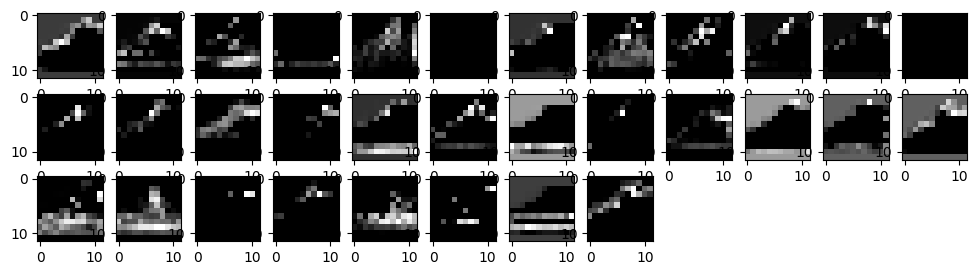

In [28]:
# Визуализировать результаты работы первого сверточного слоя
data1, target1 = next(iter(test_dataset))

img_n = 5
img_row = 5
img_col = 6
img_qty = img_row * img_col

data1_part = data1[img_n:img_n+img_qty, :, :, :]
target1_part = target1[img_n:img_n+img_qty]
output = model(data1_part)
pred = output.argmax(dim=1, keepdim=True)
correct = pred.eq(target1_part.view_as(pred)).sum().item()

with torch.no_grad():
    data1_part_1l = model.forward_1l(data1_part)
    nplots = data1_part_1l.shape[1]
    ncols = 12
    nrows = 1 + nplots//ncols
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(data1_part_1l.shape[1]):
        count += 1
        ax1 = fig.add_subplot(nrows, ncols, count)
        ax1.imshow(data1_part_1l[img_n][i], cmap='gray')
        fig.show()

##  2. Классификация изображений (датасет CIFAR 10)


### 2.1 Решить задачу классификации, не используя сверточные слои.

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [29]:
# Нормализовать данные (если необходимо)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [30]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 50000 images, in 5000 batches
The test set contains 10000 images, in 1000 batches


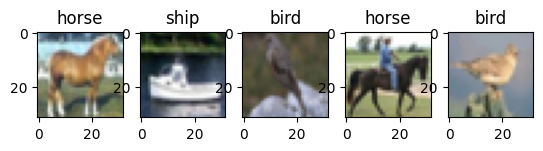

In [31]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

MEAN = torch.tensor([0.5, 0.5, 0.5])
STD = torch.tensor([0.5, 0.5, 0.5])

f, ax = plt.subplots(1, 5)
for i in range(5):
  single_img_reshaped = example_data[i] * STD[:, None, None] + MEAN[:, None, None]
  ax[i].imshow(single_img_reshaped.numpy().transpose(1, 2, 0))
  ax[i].set_title(classes[example_targets[i]])
plt.show()

In [55]:
# Предложить архитектуру модели для решения задачи

class NN_Model(nn.Module):
    def __init__(self, n_features):
        super(NN_Model, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_features, 1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

In [56]:
# Посчитать количество параметров модели.

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


n_features = 32*32*3
model = NN_Model(n_features)
count_parameters(model)

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |  3145728   |
|  fc1.bias  |    1024    |
| fc2.weight |   524288   |
|  fc2.bias  |    512     |
| fc3.weight |   131072   |
|  fc3.bias  |    256     |
| fc4.weight |   32768    |
|  fc4.bias  |    128     |
| fc5.weight |    1280    |
|  fc5.bias  |     10     |
+------------+------------+
Total Trainable Params: 3837066


3837066

In [65]:
# Обучить модель

n_features = 32*32*3
n_epoch = 15 + 1
lr=0.001
# nll_criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

model = NN_Model(n_features)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.8)
losses_list = []
log_interval = 1

start = time.time()
for epoch in range(n_epoch):
    running_loss = 0
    for images, target in train_loader:
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses = running_loss/len(train_loader)
    if epoch % log_interval == 0:
        print("Epoch: {}/{} ".format(epoch, n_epoch-1),
              "({}) ".format(time_since(start)),
              "| loss: {:.3f}..".format(losses))
    losses_list.append(losses)
print('Finished Training')

Epoch: 0/15  (2m 46s)  | loss: 2.113..
Epoch: 1/15  (5m 25s)  | loss: 1.700..
Epoch: 2/15  (7m 50s)  | loss: 1.513..
Epoch: 3/15  (10m 9s)  | loss: 1.394..
Epoch: 4/15  (12m 21s)  | loss: 1.301..
Epoch: 5/15  (14m 41s)  | loss: 1.224..
Epoch: 6/15  (16m 58s)  | loss: 1.151..
Epoch: 7/15  (19m 18s)  | loss: 1.087..
Epoch: 8/15  (21m 44s)  | loss: 1.021..
Epoch: 9/15  (24m 4s)  | loss: 0.953..
Epoch: 10/15  (26m 11s)  | loss: 0.894..
Epoch: 11/15  (28m 18s)  | loss: 0.827..
Epoch: 12/15  (30m 25s)  | loss: 0.772..
Epoch: 13/15  (32m 38s)  | loss: 0.711..
Epoch: 14/15  (34m 49s)  | loss: 0.647..
Epoch: 15/15  (36m 58s)  | loss: 0.592..
Finished Training


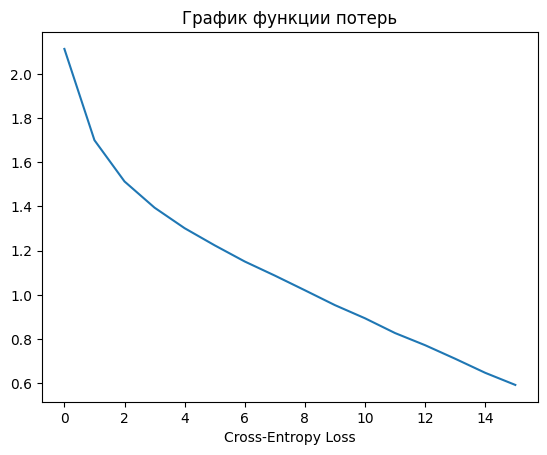

In [66]:
# Вывести график функции потерь по эпохам.

plt.plot(range(len(losses_list)), losses_list)
plt.title('График функции потерь')
plt.xlabel('Эпоха')
plt.xlabel('Cross-Entropy Loss')
plt.show()

In [67]:
# Вывести значение accuracy на тестовом множестве.
model.eval()
test_loss = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred))
        for i in range(target.shape[0]):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = correct[i].item()
            try:
              result_[target_i] += correct[i].item()
            except:
              result_[target_i] = 1
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(test_loader.dataset)

print(f'Avg. loss: {test_loss:.4f}')
print(f'Avg. accuracy: {np.sum(list(result_.values()))/np.sum(list(result_v.values())):.4f}\n')
for i in range(10):
    print(f'{classes[i]} => {result_[i]/result_v[i]:.2f}({result_[i]}/{result_v[i]})')

Avg. loss: 0.1581
Avg. accuracy: 0.5485

plane => 0.69(686/1000)
car => 0.61(612/999)
bird => 0.46(455/999)
cat => 0.37(367/1000)
deer => 0.44(443/999)
dog => 0.54(544/1000)
frog => 0.59(594/1000)
horse => 0.59(589/1000)
ship => 0.66(657/999)
truck => 0.54(535/999)


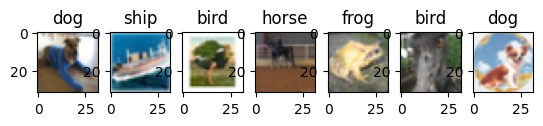

<Figure size 640x480 with 0 Axes>

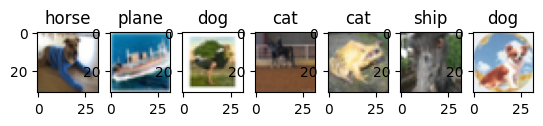

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [71]:
# Продемонстрировать работу модели: вывести несколько изображений,
# указать над ними правильный класс и класс, предсказанный моделью.

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
MEAN = torch.tensor([0.5, 0.5, 0.5])
STD = torch.tensor([0.5, 0.5, 0.5])

f, ax = plt.subplots(1, 7)
for i in range(7):
  single_img_reshaped = example_data[i] * STD[:, None, None] + MEAN[:, None, None]
  ax[i].imshow(single_img_reshaped.numpy().transpose(1, 2, 0))
  ax[i].set_title(classes[example_targets[i]])
plt.show()

plt.figure()
f, ax = plt.subplots(1, 7)
for i in range(7):
  plt.figure()
  single_img_reshaped = example_data[i] * STD[:, None, None] + MEAN[:, None, None]
  ax[i].imshow(single_img_reshaped.numpy().transpose(1, 2, 0))
  ax[i].set_title(classes[pred[i]])
plt.show()

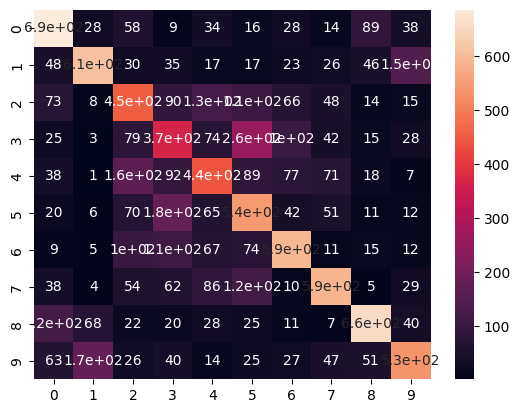

In [72]:
# Вывести матрицу ошибок.
matrix=confusion_matrix(true_list, pred_list)
ax = sns.heatmap(matrix, annot=True)
plt.show()

In [73]:
# Сохранить модель

torch.save(model.state_dict(), 'model2.pt')

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [85]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(512 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 512 * 2 * 2)
        x = self.linear(x)
        return x

    def forward_1l(self, x):
        x = self.conv1(x) # первый сверточный слой
        return x


In [87]:
model = Net()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
n_epoch = 6 + 1
log_interval = 1
criterion = nn.CrossEntropyLoss()

losses = []
start = time.time()
for epoch in range(n_epoch):
  model.train()
  running_loss = 0
  for images, target in train_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  losses = running_loss/len(train_loader)
  if i>8:
    optimizer.lr = 0.0015
  if epoch % log_interval == 0:
      print("Epoch: {}/{} ".format(epoch, n_epoch-1),
            "({}) ".format(time_since(start)),
            "| loss: {:.3f}..".format(losses))

Epoch: 0/6  (11m 5s)  | loss: 1.290..
Epoch: 1/6  (22m 21s)  | loss: 0.877..
Epoch: 2/6  (33m 4s)  | loss: 0.709..
Epoch: 3/6  (44m 8s)  | loss: 0.597..
Epoch: 4/6  (54m 53s)  | loss: 0.507..
Epoch: 5/6  (65m 40s)  | loss: 0.431..
Epoch: 6/6  (76m 12s)  | loss: 0.364..


In [90]:
# Добиться значения accuracy на тестовом множестве не менее 70%.
model.eval()
test_loss = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred))
        for i in range(target.shape[0]):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = correct[i].item()
            try:
              result_[target_i] += correct[i].item()
            except:
              result_[target_i] = 1
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(test_loader.dataset)

print(f'Avg. loss: {test_loss:.2f}')
print(f'Avg. accuracy: {np.sum(list(result_.values()))/np.sum(list(result_v.values())):.2f}\n')
for i in range(10):
    print(f'{classes[i]} => {result_[i]/result_v[i]:.2f}({result_[i]}/{result_v[i]})')

Avg. loss: 0.07
Avg. accuracy: 0.78

plane => 0.64(643/1000)
car => 0.86(863/999)
bird => 0.76(757/1000)
cat => 0.58(578/1000)
deer => 0.82(823/1000)
dog => 0.78(780/1000)
frog => 0.87(866/1000)
horse => 0.88(879/1000)
ship => 0.87(868/1000)
truck => 0.78(778/1000)


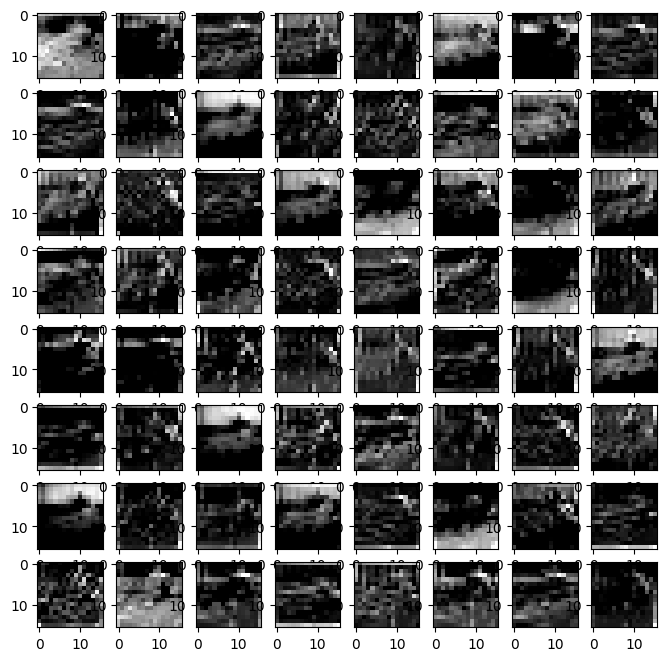

In [91]:
# Визуализировать результаты работы первого сверточного слоя
data1, target1 = next(iter(test_loader))

img_n = 1
img_row = 5
img_col = 6
img_qty = img_row * img_col

data1_part = data1[img_n:img_n+img_qty, :, :, :]
target1_part = target1[img_n:img_n+img_qty]
output = model(data1_part)
pred = output.argmax(dim=1, keepdim=True)
correct = pred.eq(target1_part.view_as(pred)).sum().item()

with torch.no_grad():
    data1_part_1l = model.forward_1l(data1_part)
    nplots = data1_part_1l.shape[1]
    ncols = 8
    nrows = 1 + nplots//ncols
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(data1_part_1l.shape[1]):
        count += 1
        ax1 = fig.add_subplot(nrows, ncols, count)
        ax1.imshow(data1_part_1l[img_n][i], cmap='gray')
        fig.show()

## 3. Загрузка изображений из внешних источников

(Датасет лежит тут => https://www.kaggle.com/datasets/slothkong/10-monkey-species)

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [5]:
# Загрузить архив с данными на диск

zf = zipfile.ZipFile('/content/drive/MyDrive/ML/4/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 2792/2792 [00:11<00:00, 244.08it/s]


In [6]:
cl = pd.read_csv(zf.extract('monkeys/monkey_labels.txt'))
cl

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [7]:
# Преобразовать изображения к тензорами одного размера
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [11]:
# Создать датасет на основе файлов при помощи torchvision.datasets.ImageFolder

train_dataset = ImageFolder(root='monkeys/training/training', transform=transform)
valid_dataset = ImageFolder(root='monkeys/validation/validation', transform=transform)

In [12]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

print("The train set contains {} images, in {} batches".format(len(train_dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(valid_dataset), len(valid_loader)))

The train set contains 1097 images, in 110 batches
The test set contains 272 images, in 28 batches


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(256 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 256 * 2 * 2)
        x = self.linear(x)
        return x

    def forward_1l(self, x):
        x = self.conv1(x) # первый сверточный слой
        return x


In [14]:
# Обучить модель.

model = Net()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
n_epoch = 15
log_interval = 1
criterion = nn.CrossEntropyLoss()

losses = []
start = time.time()
for epoch in range(1, n_epoch+1):
  model.train()
  running_loss = 0
  for images, target in train_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  losses = running_loss/len(train_loader)

  if epoch % log_interval == 0:
    print("Epoch: {}/{} ({:.2f})%|".format(epoch, n_epoch, epoch / n_epoch * 100),
          "{}|".format(time_since(start)),
            "Training loss: {:.3f}..".format(np.mean(losses)))

Epoch: 1/15 (6.67)%| 0m 59s| Training loss: 1.991..
Epoch: 2/15 (13.33)%| 1m 55s| Training loss: 1.568..
Epoch: 3/15 (20.00)%| 2m 51s| Training loss: 1.329..
Epoch: 4/15 (26.67)%| 3m 51s| Training loss: 1.204..
Epoch: 5/15 (33.33)%| 4m 49s| Training loss: 1.022..
Epoch: 6/15 (40.00)%| 5m 45s| Training loss: 0.886..
Epoch: 7/15 (46.67)%| 6m 45s| Training loss: 0.742..
Epoch: 8/15 (53.33)%| 7m 45s| Training loss: 0.681..
Epoch: 9/15 (60.00)%| 8m 42s| Training loss: 0.553..
Epoch: 10/15 (66.67)%| 9m 40s| Training loss: 0.440..
Epoch: 11/15 (73.33)%| 10m 40s| Training loss: 0.313..
Epoch: 12/15 (80.00)%| 11m 37s| Training loss: 0.294..
Epoch: 13/15 (86.67)%| 12m 34s| Training loss: 0.251..
Epoch: 14/15 (93.33)%| 13m 32s| Training loss: 0.173..
Epoch: 15/15 (100.00)%| 14m 28s| Training loss: 0.181..


In [15]:
# Вывести значение accuracy на тестовом множестве.
# Добиться значения accuracy на тестовом множестве не менее 60%

classes = cl['Latin Name'].to_list()

model.eval()
test_loss = 0
correct = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in valid_loader:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred))
        for i in range(target.shape[0]):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = correct[i].item()
            try:
              result_[target_i] += correct[i].item()
            except:
              result_[target_i] = 1
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(valid_loader.dataset)

print(f'Avg. loss: {test_loss:.4f}')
print(f'Avg. accuracy: {np.sum(list(result_.values()))/np.sum(list(result_v.values())):.4f}\n')
for i in range(10):
    print(f'{classes[i]} => {result_[i]/result_v[i]:.2f}({result_[i]}/{result_v[i]})')

Avg. loss: 0.1139
Avg. accuracy: 0.7351

alouatta_palliata => 0.73(19/26)
erythrocebus_patas => 0.43(12/28)
cacajao_calvus => 0.96(26/27)
macaca_fuscata => 0.93(27/29)
cebuella_pygmea => 0.48(12/25)
cebus_capucinus => 0.56(15/27)
mico_argentatus => 0.88(23/26)
saimiri_sciureus => 0.61(17/28)
aotus_nigriceps => 0.89(24/27)
trachypithecus_johnii => 0.88(22/25)


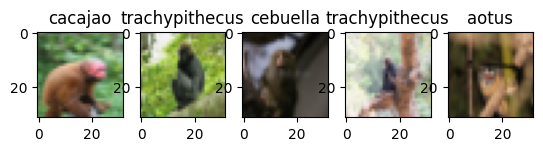

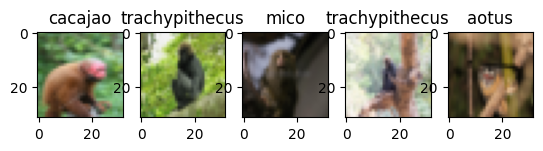

In [25]:
# Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

examples = enumerate(valid_loader)
batch_idx, (example_data, example_targets) = next(examples)
output = model(example_data)
_, pred = torch.max(output, 1)


MEAN = torch.tensor([0.5, 0.5, 0.5])
STD = torch.tensor([0.5, 0.5, 0.5])

f, ax = plt.subplots(1, 5)
for i in range(5):
  single_img_reshaped = example_data[i] * STD[:, None, None] + MEAN[:, None, None]
  ax[i].imshow(single_img_reshaped.numpy().transpose(1, 2, 0))
  ax[i].set_title(classes[example_targets[i]].split('_')[0])
plt.show()

f, ax = plt.subplots(1, 5)
for i in range(5):
  single_img_reshaped = example_data[i] * STD[:, None, None] + MEAN[:, None, None]
  ax[i].imshow(single_img_reshaped.numpy().transpose(1, 2, 0))
  ax[i].set_title(classes[pred[i]].split('_')[0])
plt.show()

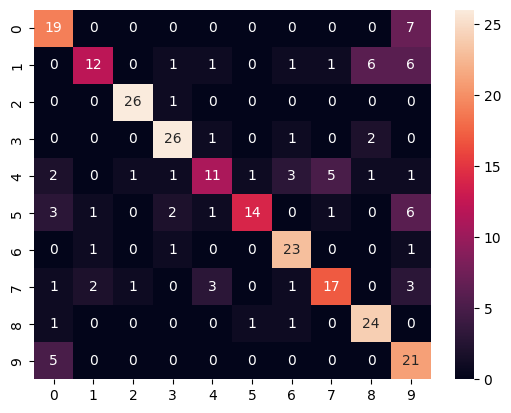

In [26]:
# Вывести матрицу ошибок.

matrix=confusion_matrix(true_list, pred_list)
ax = sns.heatmap(matrix, annot=True)
plt.show()

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

(Датасет тут => https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip)

In [44]:
# Загрузить архив с данными на диск

zf = zipfile.ZipFile('/content/drive/MyDrive/ML/4/cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 25004/25004 [00:19<00:00, 1274.86it/s]


In [45]:
transform = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [46]:
# Создать датасет на основе файлов при помощи torchvision.datasets.ImageFolder
# Преобразовать изображения к тензорами одного размера

dataset = ImageFolder(root='cats_dogs/train', transform=transform)

size = int(len(dataset) * .85)
train_dataset, valid_dataset = random_split(dataset, lengths=(size, len(dataset) - size))

In [47]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

print("The train set contains {} images, in {} batches".format(len(train_dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(valid_dataset), len(valid_loader)))

The train set contains 21250 images, in 2657 batches
The test set contains 3750 images, in 469 batches


In [48]:
# Предложить архитектуру модели для решения задачи.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(256 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 256 * 2 * 2)
        x = self.linear(x)
        return x

    def forward_1l(self, x):
        x = self.conv1(x) # первый сверточный слой
        return x


In [49]:
# Обучить модель.

model = Net()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
n_epoch = 10 + 1
log_interval = 1
criterion = nn.CrossEntropyLoss()

losses = []

start = time.time()
for epoch in range(1, n_epoch+1):
  model.train()
  running_loss = 0
  for idx, (images, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  losses = running_loss/len(train_loader)
  if epoch % log_interval == 0:
    print("Epoch: {}/{} ({:.2f})%|".format(epoch, n_epoch, epoch / n_epoch * 100),
          "{}|".format(time_since(start)),
            "Training loss: {:.3f}..".format(np.mean(losses)))

Epoch: 1/11 (9.09)%| 6m 14s| Training loss: 0.590..
Epoch: 2/11 (18.18)%| 11m 58s| Training loss: 0.444..
Epoch: 3/11 (27.27)%| 17m 55s| Training loss: 0.372..
Epoch: 4/11 (36.36)%| 24m 5s| Training loss: 0.323..
Epoch: 5/11 (45.45)%| 30m 13s| Training loss: 0.274..
Epoch: 6/11 (54.55)%| 36m 18s| Training loss: 0.225..
Epoch: 7/11 (63.64)%| 42m 18s| Training loss: 0.172..
Epoch: 8/11 (72.73)%| 48m 25s| Training loss: 0.127..
Epoch: 9/11 (81.82)%| 54m 32s| Training loss: 0.099..
Epoch: 10/11 (90.91)%| 60m 43s| Training loss: 0.080..
Epoch: 11/11 (100.00)%| 66m 57s| Training loss: 0.073..


In [66]:
# Вывести значение accuracy на тестовом множестве.
# Добиться значения accuracy на тестовом множестве не менее 80%

classes = ['cat', 'dog']
model.eval()
test_loss = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in valid_loader:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred))
        for i in range(target.shape[0]):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = correct[i].item()
            try:
              result_[target_i] += correct[i].item()
            except:
              result_[target_i] = 1
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(valid_loader.dataset)

print(f'Avg. loss: {test_loss:.4f}')
print(f'Avg. accuracy: {np.sum(list(result_.values()))/np.sum(list(result_v.values())):.4f}\n')
for i in range(2):
    print(f'{classes[i]} => {result_[i]/result_v[i]:.2f}({result_[i]}/{result_v[i]})')

Avg. loss: 0.0656
Avg. accuracy: 0.8435

cat => 0.92(1702/1858)
dog => 0.77(1461/1892)


In [71]:
examples = enumerate(valid_loader)
batch_idx, (example_data, example_targets) = next(examples)
output = model(example_data)
_, pred = torch.max(output, 1)
print(example_targets, pred)

tensor([0, 1, 1, 0, 0, 1, 1, 0]) tensor([0, 1, 1, 0, 0, 1, 0, 0])


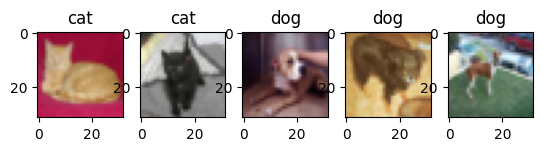

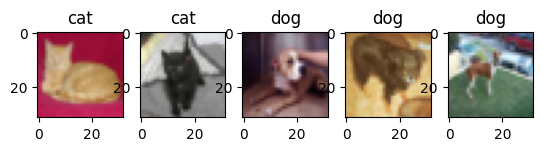

In [73]:
# Продемонстрировать работу модели: вывести несколько изображений,
# указать над ними правильный класс и класс, предсказанный моделью.

examples = enumerate(valid_loader)
batch_idx, (example_data, example_targets) = next(examples)
output = model(example_data)
_, pred = torch.max(output, 1)

MEAN = torch.tensor([0.5, 0.5, 0.5])
STD = torch.tensor([0.5, 0.5, 0.5])

f, ax = plt.subplots(1, 5)
for i in range(5):
  single_img_reshaped = example_data[i] * STD[:, None, None] + MEAN[:, None, None]
  ax[i].imshow(single_img_reshaped.numpy().transpose(1, 2, 0))
  ax[i].set_title(classes[example_targets[i]])
plt.show()

f, ax = plt.subplots(1, 5)
for i in range(5):
  single_img_reshaped = example_data[i] * STD[:, None, None] + MEAN[:, None, None]
  ax[i].imshow(single_img_reshaped.numpy().transpose(1, 2, 0))
  ax[i].set_title(classes[pred[i]])
plt.show()

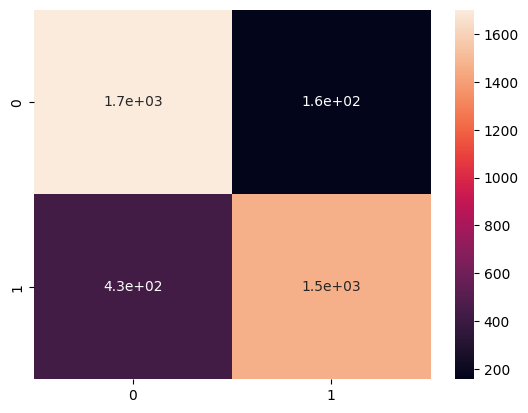

In [52]:
# Вывести матрицу ошибок.

matrix=confusion_matrix(true_list, pred_list)
ax = sns.heatmap(matrix, annot=True)
plt.show()

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)).
* Вычислить значение accuracy на тестовом множестве.


In [ ]:
# Загрузить данные для обучения

zf = zipfile.ZipFile('/content/drive/MyDrive/ML/4/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:14<00:00, 92.66it/s]


In [ ]:
# Преобразования: размер 224x224, нормализация с параметрами mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = ImageFolder(root='training/training', transform=transform)
valid_dataset = ImageFolder(root='validation/validation', transform=transform)

batch_size = 2
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

print("The train set contains {} images, in {} batches".format(len(train_dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(valid_dataset), len(valid_loader)))

The train set contains 1097 images, in 549 batches
The test set contains 272 images, in 136 batches


In [ ]:
model = models.vgg16(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = True
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Заменить последний полносвязный слой модели в соответствии с задачей

n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(n_inputs, 10)

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [ ]:
# Дообучить модель (не замораживать веса)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
n_epoch = 3
log_interval = 1
criterion = nn.CrossEntropyLoss()

losses = []
start = time.time()
for epoch in range(1, n_epoch+1):
  model.train()
  running_loss = 0
  count = 0
  for images, target in train_loader:
    count += 1
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  losses = running_loss/len(train_loader)
  if epoch % log_interval == 0:
      print("Epoch: {}/{} |".format(epoch, n_epoch),
            "{}|".format(time_since(start)),
            "Training loss: {:.3f}..".format(losses))

Epoch: 1/3 | 56m 15s| Training loss: 2.432..
Epoch: 2/3 | 117m 57s| Training loss: 2.340..
Epoch: 3/3 | 180m 36s| Training loss: 2.337..


In [ ]:
# Вычислить значение accuracy на тестовом множестве

model.eval()
test_loss = 0
correct = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in valid_loader:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred))
        for i in range(target.shape[0]):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = correct[i].item()
            try:
              result_[target_i] += correct[i].item()
            except:
              result_[target_i] = 1
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(valid_loader.dataset)

print(f'Avg. loss: {test_loss:.4f}')
print(f'Avg. accuracy: {np.sum(list(result_.values()))/np.sum(list(result_v.values())):.4f}\n')
for i in range(10):
    print(f'n{i} => {result_[i]/result_v[i]:.2f}({result_[i]}/{result_v[i]})')

Avg. loss: 1.1608
Avg. accuracy: 0.1331

n0 => 1.00(26/26)
n1 => 0.04(1/27)
n2 => 0.04(1/26)
n3 => 0.03(1/29)
n4 => 0.04(1/25)
n5 => 0.04(1/27)
n6 => 0.04(1/25)
n7 => 0.04(1/27)
n8 => 0.04(1/26)
n9 => 0.04(1/25)


Если не замораживать веса, время обучения очень большое (и за 3 эпохи достигается крайне маленькая точность)

In [ ]:
# Дообучить модель (заморозить все веса, кроме последнего блока слоев (classifier)).

model = models.vgg16(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 512), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(512, 10))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
n_epoch = 5
log_interval = 1
criterion = nn.CrossEntropyLoss()

losses = []
start = time.time()
for epoch in range(1, n_epoch+1):
  model.train()
  running_loss = 0
  for images, target in train_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  losses = running_loss/len(train_loader)
  if epoch % log_interval == 0:
      print("Epoch: {}/{} |".format(epoch, n_epoch),
            "{}|".format(time_since(start)),
            "Training loss: {:.3f}..".format(losses))

Epoch: 1/5 | 11m 56s| Training loss: 0.394..
Epoch: 2/5 | 23m 55s| Training loss: 0.190..
Epoch: 3/5 | 35m 55s| Training loss: 0.235..
Epoch: 4/5 | 47m 59s| Training loss: 0.169..
Epoch: 5/5 | 60m 0s| Training loss: 0.199..


In [ ]:
# Вычислить значение accuracy на тестовом множестве

model.eval()
test_loss = 0
correct = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in valid_loader:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred))
        for i in range(target.shape[0]):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = correct[i].item()
            try:
              result_[target_i] += correct[i].item()
            except:
              result_[target_i] = 1
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(valid_loader.dataset)

print(f'Avg. loss: {test_loss:.4f}')
print(f'Avg. accuracy: {np.sum(list(result_.values()))/np.sum(list(result_v.values())):.4f}\n')
for i in range(10):
    print(f'n{i} => {result_[i]/result_v[i]:.2f}({result_[i]}/{result_v[i]})')

Avg. loss: 0.0945
Avg. accuracy: 0.9779

n0 => 1.00(26/26)
n1 => 1.00(28/28)
n2 => 0.96(26/27)
n3 => 1.00(30/30)
n4 => 1.00(26/26)
n5 => 0.96(27/28)
n6 => 1.00(26/26)
n7 => 1.00(28/28)
n8 => 0.89(24/27)
n9 => 0.96(25/26)


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель.
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [5]:
# Загрузить данные для обучения

zf = zipfile.ZipFile('/content/drive/MyDrive/ML/4/cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 25004/25004 [00:30<00:00, 831.99it/s] 


In [6]:
# Преобразования: размер 224x224, нормализация с параметрами
# mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = ImageFolder(root='cats_dogs/train', transform=transform)

size = int(len(dataset) * .85)
train_dataset, valid_dataset = random_split(dataset, lengths=(size, len(dataset) - size))

batch_size = 2
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

print("The train set contains {} images, in {} batches".format(len(train_dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(valid_dataset), len(valid_loader)))

The train set contains 21250 images, in 10625 batches
The test set contains 3750 images, in 1875 batches


In [7]:
model = models.resnet50(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = False
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
model.fc = nn.Sequential(
    nn.Linear(2048, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.ReLU(),
    # nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(128, 2))

model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)

In [9]:
# Дообучить модель.

learning_rate = 0.0015
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
n_epoch = 2 + 1
log_interval = 1
criterion = nn.CrossEntropyLoss()

losses = []

start = time.time()
for epoch in range(1, n_epoch):
  model.train()
  running_loss = 0
  for images, target in train_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  losses = running_loss/len(train_loader)
  if epoch % log_interval == 0:
      print("Epoch: {}/{} |".format(epoch, n_epoch-1),
            "{}|".format(time_since(start)),
            "Training loss: {:.3f}..".format(losses))

Epoch: 1/2 | 96m 53s| Training loss: 0.155..
Epoch: 2/2 | 190m 46s| Training loss: 0.098..


In [11]:
# Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

classes = ['cat', 'dog']

model.eval()
test_loss = 0
correct = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in valid_loader:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred))
        for i in range(target.shape[0]):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = correct[i].item()
            try:
              result_[target_i] += correct[i].item()
            except:
              result_[target_i] = 1
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(valid_loader.dataset)

print(f'Avg. loss: {np.round(test_loss, 2)}')
print(f'Avg. accuracy: {np.round(np.sum(list(result_.values()))/np.sum(list(result_v.values())), 2)}\n')
for i in range(2):
    print(f'{classes[i]} => {np.round(result_[i]/result_v[i], 2)}({result_[i]}/{result_v[i]})')

Avg. loss: 0.1599999964237213
Avg. accuracy: 0.97

cat => 0.96(1771/1846)
dog => 0.98(1864/1903)
